## Initialization

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import argparse
from scipy import interpolate
import tqdm
import nmmn.lsd, nmmn.misc

In [4]:
# Constants, definitions and units

# many are related to grmonty, but we can set a black hole mass if we want to have a "feeling" for the physical values

global MP, ME, CL, GNEWT, KBOL, SIGMA_THOMSON, MSUN, LSUN, YEAR, MBH
global TPTE_DISK, TPTE_JET, THETAE_MAX
global M_unit, L_unit, T_unit, RHO_unit, U_unit, B_unit, Ne_unit

# all constants in cgs units
ME = 9.1093826e-28 # electron mass
MP = 1.67262171e-24 # proton mass
CL = 2.99792458e10 # speed of light
GNEWT = 6.6742e-8 # gravitational constant
KBOL = 1.3806505e-16 # Boltzmann constant
SIGMA_THOMSON = 0.665245873e-24 # Thomson cross-section
MSUN = 1.989e33 # solar mass
LSUN = 3.827e33 # solar luminosity
YEAR = 31536000 # seconds in a year

# temperature and beta-prescription (Mościbrodzka 2016)
TPTE_DISK = 20. # R_high
TPTE_JET = 1. # R_low
THETAE_MAX = 1000.
TP_OVER_TE = 100.0

# grmonty units and BH mass
MBH = 4.5e6 * MSUN # Sgr A*
#MBH = 6.2e9 * MSUN # M87
#MBH = 5.0e9 * MSUN
#MBH = 10.0 * MSUN
M_unit = 1.0e19
#M_unit = 2.0*10e11
L_unit = GNEWT * MBH / (CL * CL)
T_unit = L_unit / CL
RHO_unit = M_unit / (L_unit*L_unit*L_unit)
U_unit = RHO_unit * CL * CL
B_unit = CL * np.sqrt(4. * np.pi * RHO_unit)
Ne_unit = RHO_unit / (MP + ME)

## Characterization of current sheets

In [5]:
%run -i harm_script2.py
rg("gdump")
rd("dump065")

harm_script2.py:731: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


In [6]:
sigmaphi = bu[3]*bd[3]/(rho)
bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
jcurr = np.nan_to_num(jcurr)
sigma = (bu[0]*bd[0] + bu[1]*bd[1] + bu[2]*bd[2] + bu[3]*bd[3])/rho
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = sqrt(Jsq)

harm_script2.py:9: RuntimeWarning: invalid value encountered in sqrt
  from matplotlib.patches import Ellipse


In [189]:
degrees(0.27)

15.469860468532229

In [187]:
sigma[46,4]

array([50.], dtype=float32)

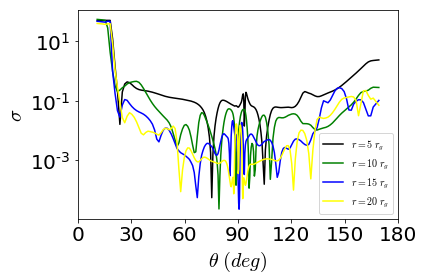

In [212]:
hdeg = degrees(h[0])
hfont = {'fontname':'Helvetica'}
plt.plot(hdeg,sigma[55], label = r'$r = 5\;r_g$', color = 'black')
plt.plot(hdeg,sigma[83], label = r'$r = 10\;r_g$', color='green')
plt.plot(hdeg,sigma[99], label = r'$r = 15\;r_g$', color ='blue')
plt.plot(hdeg,sigma[110], label = r'$r = 20\;r_g$', color='yellow')
plt.yscale('log')
plt.xlabel(r'$\theta\;(deg)$')
plt.ylabel(r'$\sigma$')
plt.xticks(np.arange(0, 181, step=30)) #GS
#plt.yticks(np.arange(0, 1, step=50)) #GS
plt.legend()
plt.tight_layout() # GS
plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/sigma_radius.png", dpi = 200)


### Regrid

In [33]:
def regrid(radius, angle, bu3, jcurr, JJ_cs, n1, n2, xlim = None):
 
    """
        bu3: b_phi
        jcurr: current
        JJ_cs: only current sheet
    
    """
    
    if(xlim == None):
        xlim = radius.max()
    
    n1new = 3000
    n2new = 3000
    
    angle = -(angle-numpy.pi/2.) # spherical angle => polar angle

    xnew = numpy.linspace(0, xlim, n1new)
    ynew = numpy.linspace(-xlim, xlim, n2new)
    
    #new_rg_x = xnew*xlim/n1new
    #new_rg_y = new_rg_x - 0.5*n2new

    new_bu3   = numpy.zeros((n1new, n2new))
    new_jcurr = numpy.zeros((n1new, n2new))
    new_JJcs  = numpy.zeros((n1new, n2new))

    # *****BOTTLENECK*****
    # goes through new array
    for i in range(xnew.size):
        for j in range(ynew.size):
                    
            rnew, thnew = nmmn.misc.cart2pol(xnew[i], ynew[j])
            # position in old array
            iref = nmmn.lsd.search(rnew, radius)
            jref = nmmn.lsd.search(thnew, angle)

            new_bu3[j,i]   = bu3[iref,jref]
            new_jcurr[j,i] = jcurr[iref,jref]
            new_JJcs[j,i]  = JJ_cs[iref,jref]
    # *****END BOTTLENECK*****
        
    return new_bu3, new_jcurr, new_JJcs, n1new, n2new, xnew, ynew

In [34]:
c_bu3 = bu[3][:,:,0]
c_jcurr = jcurr[:,:,0]
c_JJcs = JJ_cs[:,:,0]
c_r = r[:,0,0]#.flatten()
c_h = h[0,:,0]#.flatten()

In [35]:
r0 = 1.1951147
r1 = 1.2411376
deltar = r1 - r0
print(deltar)
print(100/deltar)

0.04602290000000009
2172.831351348998


In [36]:
%%time
n_bu3, n_jcurr, n_JJcs, nx_new, ny_new, rgx, rgy = regrid (c_r, c_h, c_bu3, c_jcurr, c_JJcs, nx, ny, xlim=80)

CPU times: user 1min 33s, sys: 396 ms, total: 1min 33s
Wall time: 1min 33s


In [37]:
def withinlimits(icell, jcell):
    
    if (icell >= nx_new): icell = nx_new-1
    elif (icell < 0): icell = 0
    if (jcell >= ny_new): jcell = ny_new-1
    elif (jcell < 0): jcell = 0
        
    return icell, jcell

In [38]:
def alongplus(i, j, mat, slope, intercept, dist_increase, thr):

    global ip, jp, bp, bp_arr, jcurrp, jp_arr, xp, yp

    bp_arr = []
    jp_arr = []
    dist = 0
    k = 0

    while True:
        ip = i + dist
        jp = slope*ip + intercept
        
        if (ip < 0 or jp < 0):
            break
                
        # round cells
        ip = int(round(ip))
        jp = int(round(jp))
    
        # make sure the cells are within grid limits
        ip, jp = withinlimits(ip, jp)
                    
        # get physical quantities
        bp = mat[ip][jp]
        jcurrp = n_jcurr[ip][jp]
                
        if (dist > thr):
            #xp = ip
            #yp = jp
            break
                                
        # append quantities to arrays
        bp_arr.append(bp)
        jp_arr.append(jcurrp)
        
        # get current "last" member of sequence coordinates and increase distance
        xp = ip#r[ip][jp] * np.sin(h[ip][jp])
        yp = jp#r[ip][jp] * np.cos(h[ip][jp])
        dist += dist_increase
        
def alongminus(i, j, mat, slope, intercept, dist_increase, thr):

    global im, jm, bm, bm_arr, jcurr, jm_arr, xm, ym

    bm_arr = []
    jm_arr = []
    dist = 0
    k = 0

    while True:       
        im = i - dist
        jm = slope*im + intercept
        
        if (im < 0 or jm < 0):
            break
                
        # round cells
        im = int(round(im))
        jm = int(round(jm))
    
        # make sure the cells are within grid limits
        im, jm = withinlimits(im, jm)
                    
        # get physical quantities
        bm = mat[im][jm]
        jcurrm = n_jcurr[im][jm]
                
        if (dist > thr):
            #xm = im
            #ym = jm
            break
                                
        # append quantities to arrays
        bm_arr.append(bm)
        jm_arr.append(jcurrm)

        # get current "last" member of sequence coordinates and increase distance
        xm = im#r[im][jm] * np.sin(h[im][jm])
        ym = jm#r[im][jm] * np.cos(h[im][jm])
        dist += dist_increase
                
def get_intercept(x, y, slope):
    return y - slope * x

In [39]:
BOXSIZE = 25#11
LIMIT = int(BOXSIZE/2 - 0.5)
Bu3_THR = 10e-2
dist_increase = 0.2
thr = 5
n_bphi = n_bu3*B_unit

In [14]:
#print(n_JJcs[n_JJcs != 0])
#print(JJ_cs[JJ_cs != 0])
#np.where(n_JJcs != 0)
#np.where(np.abs(n_bphi) < Bu3_THR)

### All points

In [51]:
k = 0

#for i in range(LIMIT, nx_new-LIMIT, 1):
#for i in range(1498, nx_new-LIMIT, 1):
for i in range(1600, 1800, 1):
    #for j in range(LIMIT, ny_new-LIMIT, 1):
    for j in range(LIMIT, 290-LIMIT, 1):

        xc = i#r[i][j] * np.sin(h[i][j])
        yc = j#r[i][j] * np.cos(h[i][j])

        if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
            # get box limits
            ibox_min = i - LIMIT
            jbox_min = j - LIMIT
            ibox_max = i + LIMIT
            jbox_max = j + LIMIT
            
            # check within box
            nbox = 0
            theta = 0
            for ibox in range(ibox_min, ibox_max+1, 1):
                for jbox in range(jbox_min, jbox_max+1, 1):
                    
                    # make sure we are not applying this to our central point (i,j)
                    if ((i == ibox) and (j == jbox)):
                        continue
                    
                    # check if point belongs to sheet
                    elif((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
                        # get angle
                        nbox += 1
                        if (i == ibox):
                            theta += 0
                        else:
                            theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
            # once we finish the box, we get the average slope
            theta = theta/nbox
            slope = np.tan(theta)
            normal = -1./slope
            intercept = get_intercept(i, j, normal)

            alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
            alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

            print("xm,ym,xp,yp,slope,intercept")
            print(xm,ym,xp,yp,slope,intercept)
            
            bp_arr = np.asarray(bp_arr)
            bm_arr = np.asarray(bm_arr)
            jp_arr = np.asarray(jp_arr)
            jm_arr = np.asarray(jm_arr)

            # flip m array so we can have a continuous array with p and m quantities
            bm_arr = np.flip(bm_arr, 0)
            jm_arr = np.flip(jm_arr, 0)
            bplot = np.append(bm_arr, bp_arr)
            jplot = np.append(jm_arr, jp_arr)

            # normalize jplot
            jplot = jplot/np.max(jplot)

            plt.figure(num=1, figsize=(6,4))

            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            #rcParams['font.size'] = 8

            myvar = n_bu3*B_unit
            plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
            ax = plt.gca()
            ax.set_aspect(1)
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            plt.xticks(np.arange(0, 21, step=5))
            plt.yticks(np.arange(-10, 11, step=5))
            plt.xlim(0,20)
            plt.ylim(-10,10)
            fig = plt.gcf()
            plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
            plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
            cbar = plt.colorbar()
            cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
            #generate ellipse object
            #import the Ellipse function
            from matplotlib.patches import Ellipse
            #create Ellipse "actor"
            el = Ellipse((0,0), #origin of ellipse
                2*rhor, 2*rhor, #major axes of ellipse
                facecolor='black', #color of ellipse
                alpha=1) #opacity of ellipse
            ax=plt.gca() #get current axes
            art=ax.add_artist(el) #show object in axes
            art.set_zorder(20) #bring ellipse to front
            plt.tight_layout()  # otherwise the right y-label is slightly clipped

            ax1 = fig.add_axes([0.475, 0.295, 0.23, 0.23])
            ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
            color = 'xkcd:dark purple'
            ax1.set_xlabel('dist (arbitrary units)', fontsize = 8)
            ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
            ax1.plot(bplot, color=color)
            ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
            ax1.tick_params(axis='x', labelsize = 8)
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'xkcd:dark orange'
            ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
            ax2.plot(jplot, color=color)
            ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
            plt.tight_layout()  # otherwise the right y-label is slightly clipped
            
            plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/%d_%d_%d.png" %(j, i, k), dpi = 250)
            plt.close()

### Single point

In [40]:
#i = 1498
#j = 56

i = 1554
j = 41

k = 0

xc = i#r[i][j] * np.sin(h[i][j])
yc = j#r[i][j] * np.cos(h[i][j])


if((n_JJcs[i][j] != 0) and (np.abs(n_bu3[i][j]) < Bu3_THR)):
    # get box limits
    ibox_min = i - LIMIT
    jbox_min = j - LIMIT
    ibox_max = i + LIMIT
    jbox_max = j + LIMIT
            
    # check within box
    nbox = 0
    theta = 0
    for ibox in range(ibox_min, ibox_max+1, 1):
        for jbox in range(jbox_min, jbox_max+1, 1):
                    
            # make sure we are not applying this to our central point (i,j)
            if ((i == ibox) and (j == jbox)):
                continue
                    
            # check if point belongs to sheet
            if((n_JJcs[i][j] != 0) and (np.abs(n_bu3[i][j]) < Bu3_THR)):       
                # get angle
                nbox += 1
                if (i == ibox):
                    theta += 0
                else:
                    theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
    # once we finish the box, we get the average slope
    theta = theta/nbox
    slope = np.tan(theta)
    slope = 0.575
    normal = -1./slope
    intercept = get_intercept(i, j, normal)

    alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
    alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

    bp_arr = np.asarray(bp_arr)
    bm_arr = np.asarray(bm_arr)
    jp_arr = np.asarray(jp_arr)
    jm_arr = np.asarray(jm_arr)

    # flip m array so we can have a continuous array with p and m quantities
    bm_arr = np.flip(bm_arr, 0)
    jm_arr = np.flip(jm_arr, 0)
    bplot = np.append(bm_arr, bp_arr)
    jplot = np.append(jm_arr, jp_arr)

    # normalize jplot
    jplot = jplot/np.max(jplot)

    # plot snapshots

    plt.figure(num=1, figsize=(6,4))

    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    #rcParams['font.size'] = 8

    myvar = n_bu3*B_unit
    plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    plt.xticks(np.arange(0, 21, step=5))
    plt.yticks(np.arange(-10, 11, step=5))
    plt.xlim(0,20)
    plt.ylim(-10,10)
    fig = plt.gcf()
    plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
    plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
    cbar = plt.colorbar()
    cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
    #generate ellipse object
    #import the Ellipse function
    from matplotlib.patches import Ellipse
    #create Ellipse "actor"
    el = Ellipse((0,0), #origin of ellipse
        2*rhor, 2*rhor, #major axes of ellipse
        facecolor='black', #color of ellipse
        alpha=1) #opacity of ellipse
    ax=plt.gca() #get current axes
    art=ax.add_artist(el) #show object in axes
    art.set_zorder(20) #bring ellipse to front
    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    
    from matplotlib.ticker import FormatStrFormatter
    
    ax1 = fig.add_axes([0.43, 0.5, 0.25, 0.25])
    ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
    color = 'xkcd:green'
    ax1.set_xlabel(r'$\mathrm{distance}\;(r_g)$', fontsize = 8, color = 'yellow')
    sizeline = np.sqrt((rgx[ym] - rgx[yp])**2 + (rgy[xm] - rgy[xp])**2)
    my_xticks = [0.00,0.17,0.34,0.51,0.68]
    ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
    ax1.plot(bplot, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
    ax1.tick_params(axis='x', labelsize = 8, color = 'yellow')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'xkcd:dark orange'
    ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
    ax2.plot(jplot, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/%d_%d_%d.png" %(j, i, k), dpi = 200)
    plt.close()

/home/gustavo/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [41]:
rgx[yc]

1.0936978992997666

In [42]:
rgy[xc]

2.907635878626209

In [50]:
rrrr = np.sqrt(rgx[yc]**2 + rgy[xc]**2)
thth = np.arctan(rgy[xc]/rgx[yc])

In [53]:
rrrr 3.10800934e+00

3.10652885027761

In [54]:
thth 1.2146679

1.2110206317370797

In [69]:
r[36,0,0]

3.1080093

In [76]:
h[0,49,0]

1.2146679

In [82]:
bplot

array([ 8.19099389e+01,  8.19099389e+01,  7.59261128e+01,  5.59484931e+01,
        5.59484931e+01,  5.59484931e+01,  5.59484931e+01,  5.15773817e+01,
        5.15773817e+01,  3.45947165e+01,  3.45947165e+01,  3.45947165e+01,
        3.45947165e+01,  3.45947165e+01,  1.82460709e+01,  1.82460709e+01,
        1.82460709e+01,  1.52043980e+01,  1.52043980e+01,  1.52043980e+01,
        1.61379487e+00,  1.61379487e+00, -6.14220386e-02, -6.14220386e-02,
       -6.14220386e-02, -6.14220386e-02, -6.14220386e-02, -9.48140408e+00,
       -9.95703941e+00, -9.95703941e+00, -9.48140408e+00, -9.48140408e+00,
       -9.48140408e+00, -2.16683129e+01, -2.16683129e+01, -2.16683129e+01,
       -2.16683129e+01, -2.16683129e+01, -5.13996864e+01, -5.13996864e+01,
       -5.13996864e+01, -5.13996864e+01, -5.13996864e+01, -4.87394320e+01,
       -6.65105625e+01, -6.65105625e+01, -6.65105625e+01, -6.65105625e+01,
       -6.65105625e+01, -6.65105625e+01])

In [65]:
np.sqrt((rgx[ym] - rgx[yp])**2 + (rgy[xm] - rgy[xp])**2)

0.6832276612132508

In [63]:
rgx[ym]

1.708516599008606

In [64]:
rgx[yp]

0.7749165249147738

In [60]:
rgy[xm]

2.640880293431138

In [61]:
rgy[xp]

3.17439146382128

In [50]:
rgx[41]

1.0936978992997666

In [48]:
rgy[1554]

2.907635878626209

In [ ]:
bb1 = bplot/np.max(bplot)

In [ ]:
bb2 = bplot/np.max(bplot)

In [ ]:
bb3 = bplot/np.max(bplot)

In [ ]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
plt.title(r'$b_\phi$ profiles at current sheets: normalized sample')
plt.xlabel('dist (arbitrary units)', fontsize = 12)
plt.ylabel(r'$b_\phi\;(G)$')
plt.plot(bb1, color = 'red')
plt.plot(bb2, color = 'blue')
plt.plot(bb3, color = 'green')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("/home/gustavo/profiles/many_bs.png", dpi = 200)
plt.close()

### Plot only

In [ ]:
# plot snapshots

plt.figure(num=1, figsize=(6,4))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
#rcParams['font.size'] = 8

myvar = n_bu3*B_unit
plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
plt.xticks(np.arange(0, 21, step=5))
plt.yticks(np.arange(-10, 11, step=5))
plt.xlim(0,20)
plt.ylim(-10,10)
fig = plt.gcf()
plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='xkcd:teal', linestyle='-', linewidth=0.5)
plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
#generate ellipse object
#import the Ellipse function
from matplotlib.patches import Ellipse
#create Ellipse "actor"
el = Ellipse((0,0), #origin of ellipse
    2*rhor, 2*rhor, #major axes of ellipse
    facecolor='black', #color of ellipse
    alpha=1) #opacity of ellipse
ax=plt.gca() #get current axes
art=ax.add_artist(el) #show object in axes
art.set_zorder(20) #bring ellipse to front
plt.tight_layout()  # otherwise the right y-label is slightly clipped

ax1 = fig.add_axes([0.475, 0.295, 0.23, 0.23])
ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
color = 'xkcd:dark purple'
ax1.set_xlabel('dist (arbitrary units)', fontsize = 8)
ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
ax1.plot(bplot, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
ax1.tick_params(axis='x', labelsize = 8)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'xkcd:dark orange'
ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
ax2.plot(jplot, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
"""
# plot profiles
ax1 = plt.subplot(122)
color = 'tab:blue'
ax1.set_xlabel('dist')
ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
ax1.plot(bplot, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
ax2.plot(jplot, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
"""
plt.savefig("/home/gustavo/profiles/doubleplot_%d_%d_%d.png" %(j, i, k), dpi = 250)
plt.close()

## Current sheets

In [7]:
#Jfile = "/work/gustavo/2ds9/harmpi-master/current_sheets/dump065_jcs"
#Jfile = "/work/gustavo/2ds9/harmpi-master/current_sheets/dump065_jcs_peak"
Jfile = "/home/gustavo/Dropbox/trabalho/career/current_sheets/dump065_jcs"

Jdata = np.loadtxt(Jfile)
JJ_cs = np.reshape(Jdata, (int(N1), int(N2), int(N3)))

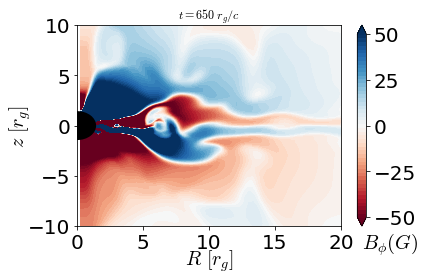

In [151]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(Bphi, levels=np.linspace(-50,50), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap='RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
cb.ax.set_xlabel(r"$B_\phi(G)$",fontsize=20,ha="left")
cb.set_ticks([-50,-25,0,25,50])
plt.xticks(np.arange(0, 21, step = 5))
plt.yticks(np.arange(-10, 11, step = 5))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)
#plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
#plot([rgx[ym]-0.35, rgx[yp]-0.35], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
plt.savefig("Bphi_t0650.png", format = "png", dpi = 300)
#plt.clf

/home/gustavo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'ticks'
  s)
/home/gustavo/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


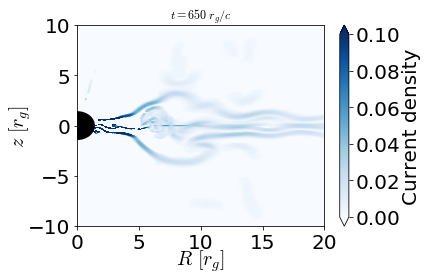

In [8]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(JJ_cs, levels=np.linspace(0,10e-2,100), ticks=[0, 0.05, 0.1], isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, 21, step = 5))
plt.yticks(np.arange(-10, 11, step = 5))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
plt.savefig("sheets_t0650.png", format = "png", dpi = 300)
#plt.clf

In [31]:
JJ_cs2 = JJ_cs
JJ_cs2[JJ_cs2 > 0] = 1

In [49]:
JJ_cs2.shape

(288, 192, 1)

In [63]:
r[:,0,0]

array([1.26491952e+00, 1.29690409e+00, 1.32969749e+00, 1.36332011e+00,
       1.39779282e+00, 1.43313730e+00, 1.46937549e+00, 1.50652993e+00,
       1.54462397e+00, 1.58368111e+00, 1.62372589e+00, 1.66478336e+00,
       1.70687890e+00, 1.75003886e+00, 1.79429018e+00, 1.83966041e+00,
       1.88617790e+00, 1.93387151e+00, 1.98277128e+00, 2.03290749e+00,
       2.08431125e+00, 2.13701487e+00, 2.19105124e+00, 2.24645400e+00,
       2.30325770e+00, 2.36149764e+00, 2.42121005e+00, 2.48243260e+00,
       2.54520321e+00, 2.60956097e+00, 2.67554593e+00, 2.74319959e+00,
       2.81256390e+00, 2.88368201e+00, 2.95659852e+00, 3.03135872e+00,
       3.10800934e+00, 3.18659830e+00, 3.26717424e+00, 3.34978771e+00,
       3.43449020e+00, 3.52133417e+00, 3.61037445e+00, 3.70166588e+00,
       3.79526591e+00, 3.89123249e+00, 3.98962593e+00, 4.09050703e+00,
       4.19393921e+00, 4.29998684e+00, 4.40871572e+00, 4.52019405e+00,
       4.63449144e+00, 4.75167894e+00, 4.87182903e+00, 4.99501801e+00,
      

/home/gustavo/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


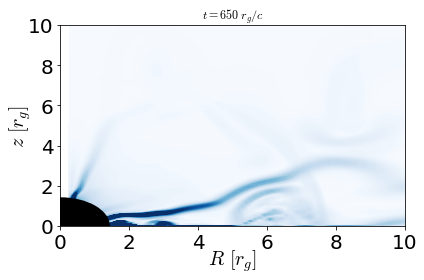

In [60]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs = plco(JJJ, levels=np.linspace(0,0.1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=10, dobh=1, cb=0, extend = "both", pretty=1, cmap = 'Blues')
plt.contourf(JJ_cs2[:,:,0], color ='yellow')
#cs2 = plco(JJ_cs2, color='yellow')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, 11, step = 2))
plt.yticks(np.arange(0, 11, step = 2))
plt.xlim(0,10)
plt.ylim(0,10)
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
plt.savefig("current.png", format = "png", dpi = 300)
#plt.clf

## SANDBOX

Plotting, old way

In [ ]:
    
    """
    # plot profiles
    fig, ax1 = plt.subplots()
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    color = 'tab:blue'
    ax1.set_xlabel('dist')
    ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
    ax1.plot(bplot, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
    ax2.plot(jplot, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig("/home/gustavo/profiles/prof/%d_%d_%d.png" %(j, i, k), dpi = 200)
    plt.close()
    
    # plot snapshots
    myvar = n_bu3*B_unit
    plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    plt.xticks(np.arange(0, 21, step=5))
    plt.yticks(np.arange(-10, 11, step=5))
    plt.xlim(0,20)
    plt.ylim(-10,10)
    fig = plt.gcf()
    plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
    plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
    cbar = plt.colorbar()
    cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
    #generate ellipse object
    #import the Ellipse function
    from matplotlib.patches import Ellipse
    #create Ellipse "actor"
    el = Ellipse((0,0), #origin of ellipse
        2*rhor, 2*rhor, #major axes of ellipse
        facecolor='black', #color of ellipse
        alpha=1) #opacity of ellipse
    ax=plt.gca() #get current axes
    art=ax.add_artist(el) #show object in axes
    art.set_zorder(20) #bring ellipse to front
    plt.draw() #make sure it's drawn
    fig.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(j, i, k), dpi = 250)
    plt.close()
"""
    #plt.imshow(n_bu3*B_unit)
    #plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    #plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
    #plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    #plt.close()
    """
    cs, cb = plco(n_bu3*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
    plt.xticks(np.arange(0, 21, step=2))
    fig = plt.gcf()
    plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
    #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
    #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
    plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
    plt.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    plt.close()  
    """
    #plt.imshow(n_bu3, origin='lower', cmap='RdBu', vmin=-0.02, vmax=0.02)
    #plt.imshow(myvar, origin='lower', cmap='RdBu', vmin=-25.0, vmax=25.0, extent=[-myvar.shape[1]/2., myvar.shape[1]/2., -myvar.shape[0]/2., myvar.shape[0]/2.])
    #plt.imshow(myvar, origin='lower', cmap='RdBu', vmin=-25.0, vmax=25.0, interpolation = 'none', extent=[0,myvar.shape[1], -myvar.shape[0]/2., myvar.shape[0]/2.])

In [ ]:
"""   
k = 0

#for i in range(LIMIT, nx_new-LIMIT, 1):
#for i in range(1498, nx_new-LIMIT, 1):
for i in range(1487, 1493, 1):
    #for j in range(LIMIT, ny_new-LIMIT, 1):
    for j in range(LIMIT, 290-LIMIT, 1):

        xc = i#r[i][j] * np.sin(h[i][j])
        yc = j#r[i][j] * np.cos(h[i][j])

        if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
            # get box limits
            ibox_min = i - LIMIT
            jbox_min = j - LIMIT
            ibox_max = i + LIMIT
            jbox_max = j + LIMIT
            
            # check within box
            nbox = 0
            theta = 0
            for ibox in range(ibox_min, ibox_max+1, 1):
                for jbox in range(jbox_min, jbox_max+1, 1):
                    
                    # make sure we are not applying this to our central point (i,j)
                    if ((i == ibox) and (j == jbox)):
                        continue
                    
                    # check if point belongs to sheet
                    if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
                        # get angle
                        nbox += 1
                        if (i == ibox):
                            theta += 0
                        else:
                            theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
            # once we finish the box, we get the average slope
            theta = theta/nbox
            slope = np.tan(theta)
            normal = -1./slope
            intercept = get_intercept(i, j, normal)

            alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
            alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

            print("xm,ym,xp,yp,slope,intercept")
            print(xm,ym,xp,yp,slope,intercept)
            
            bp_arr = np.asarray(bp_arr)
            bm_arr = np.asarray(bm_arr)
            jp_arr = np.asarray(jp_arr)
            jm_arr = np.asarray(jm_arr)

            # flip m array so we can have a continuous array with p and m quantities
            bm_arr = np.flip(bm_arr, 0)
            jm_arr = np.flip(jm_arr, 0)
            bplot = np.append(bm_arr, bp_arr)
            jplot = np.append(jm_arr, jp_arr)

            # normalize jplot
            jplot = jplot/np.max(jplot)

            # plot profiles
            fig, ax1 = plt.subplots()
            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            color = 'tab:blue'
            ax1.set_xlabel('dist')
            ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
            ax1.plot(bplot, color=color)
            ax1.tick_params(axis='y', labelcolor=color)
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:red'
            ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
            ax2.plot(jplot, color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            #plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.savefig("/home/gustavo/profiles/prof/%d_%d_%d.png" %(j, i, k), dpi = 200)
            plt.close()
    
            # plot snapshots
            myvar = n_bu3*B_unit
            plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            ax = plt.gca()
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            plt.xticks(np.arange(0, 21, step=5))
            plt.yticks(np.arange(-10, 11, step=5))
            plt.xlim(0,20)
            plt.ylim(-10,10)
            fig = plt.gcf()
            plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
            plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
            cbar = plt.colorbar()
            cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
            #generate ellipse object
            #import the Ellipse function
            from matplotlib.patches import Ellipse
            #create Ellipse "actor"
            el = Ellipse((0,0), #origin of ellipse
                2*rhor, 2*rhor, #major axes of ellipse
                facecolor='black', #color of ellipse
                alpha=1) #opacity of ellipse
            ax=plt.gca() #get current axes
            art=ax.add_artist(el) #show object in axes
            art.set_zorder(20) #bring ellipse to front
            plt.draw() #make sure it's drawn
            fig.tight_layout()
            plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(j, i, k), dpi = 250)
            plt.close()

 """
    #plt.imshow(n_bu3*B_unit)
    #plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    #plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
    #plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    #plt.close()
    """
    cs, cb = plco(n_bu3*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
    plt.xticks(np.arange(0, 21, step=2))
    fig = plt.gcf()
    plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
    #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
    #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
    plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
    plt.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    plt.close()  
    """
    
            
            
"""
            cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
            ax = plt.gca()
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
            plt.xticks(np.arange(0, 21, step=2))
            fig = plt.gcf()
            plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
            plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
            #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
            #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
            plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
            plt.tight_layout()
            plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 150)
            plt.close()           
"""
            
            
